<p align="center">
    <a href="https://predict-idlab.github.io/landmarker">
        <img alt="landmarker" src="https://raw.githubusercontent.com/predict-idlab/landmarker/main/docs/_static/images/logo.svg" width="66%">
    </a>
</p>

# Training and Evaluating Static Heatmap Regression Model for Multi-Instance and Single-Class Landmark Detetection (Plant Centroids)

We will go through the following steps:
* [Loading the dataset](#Loading-the-dataset)
* [Inspecting the dataset](#Inspecting-the-dataset)
* [Training and initializing the UNet model](#Training-the-model)
* [Evaluating the model](#Evaluating-the-model)

<a target="_blank" href="https://colab.research.google.com/github/predict-idlab/landmarker/examples/static_unet_plant_centroids.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup environment

In [1]:
# !python -c "import landmarker" || pip install landmarker

import sys
import os

sys.path.append("../src/")
import landmarker

## Setup imports and variables

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from monai.transforms import (Compose, RandAffined, RandGaussianNoised, RandStdShiftIntensityd,
                              RandScaleIntensityd, RandAdjustContrastd, RandHistogramShiftd,
                              ScaleIntensityd, Lambdad)
from tqdm.notebook import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading the dataset

In [4]:
from landmarker.transforms.images import UseOnlyFirstChannel
fn_keys = ('image',)
spatial_transformd = [RandAffined(fn_keys, prob=1,
                        rotate_range=(-np.pi/12, np.pi/12),
                        translate_range=(-10, 10),
                        scale_range=(-0.1, 0.1),
                        shear_range=(-0.1, 0.1)
                        )]

train_transformd = Compose([
                            ScaleIntensityd(('image', )),  # Scale intensity
                        ] + spatial_transformd)

inference_transformd = Compose([
    ScaleIntensityd(('image', )),
])

In [5]:
from landmarker.datasets import get_plant_centroids_landmark_datasets

data_dir = "/Users/jefjonkers/Data/landmark-datasets"
ds_train, ds_test_A, ds_test_B, ds_test_C = get_plant_centroids_landmark_datasets(data_dir, train_transform = train_transformd,
                                                                                  inference_transform=inference_transformd,
                                                                                  dim_img=(512,512),
                                                                                  store_imgs=False)

100%|██████████| 234/234 [00:00<00:00, 57365.55it/s]


Reading and extracting masks from 1398 images...


100%|██████████| 1398/1398 [00:05<00:00, 253.85it/s]


Reading and extracting masks from 100 images...


100%|██████████| 100/100 [00:00<00:00, 246.31it/s]


Reading and extracting masks from 275 images...


100%|██████████| 275/275 [00:01<00:00, 263.84it/s]


Reading and extracting masks from 234 images...


100%|██████████| 234/234 [00:00<00:00, 267.46it/s]


## Constructing a heatmap generator

In [6]:
from landmarker.heatmap.generator import GaussianHeatmapGenerator

heatmap_generator = GaussianHeatmapGenerator(
    nb_landmarks=1,
    sigmas=3,
    gamma=None,
    heatmap_size=(512, 512),
    learnable=False, # If True, the heatmap generator will be trainable
).to(device)

## Inspecting the dataset

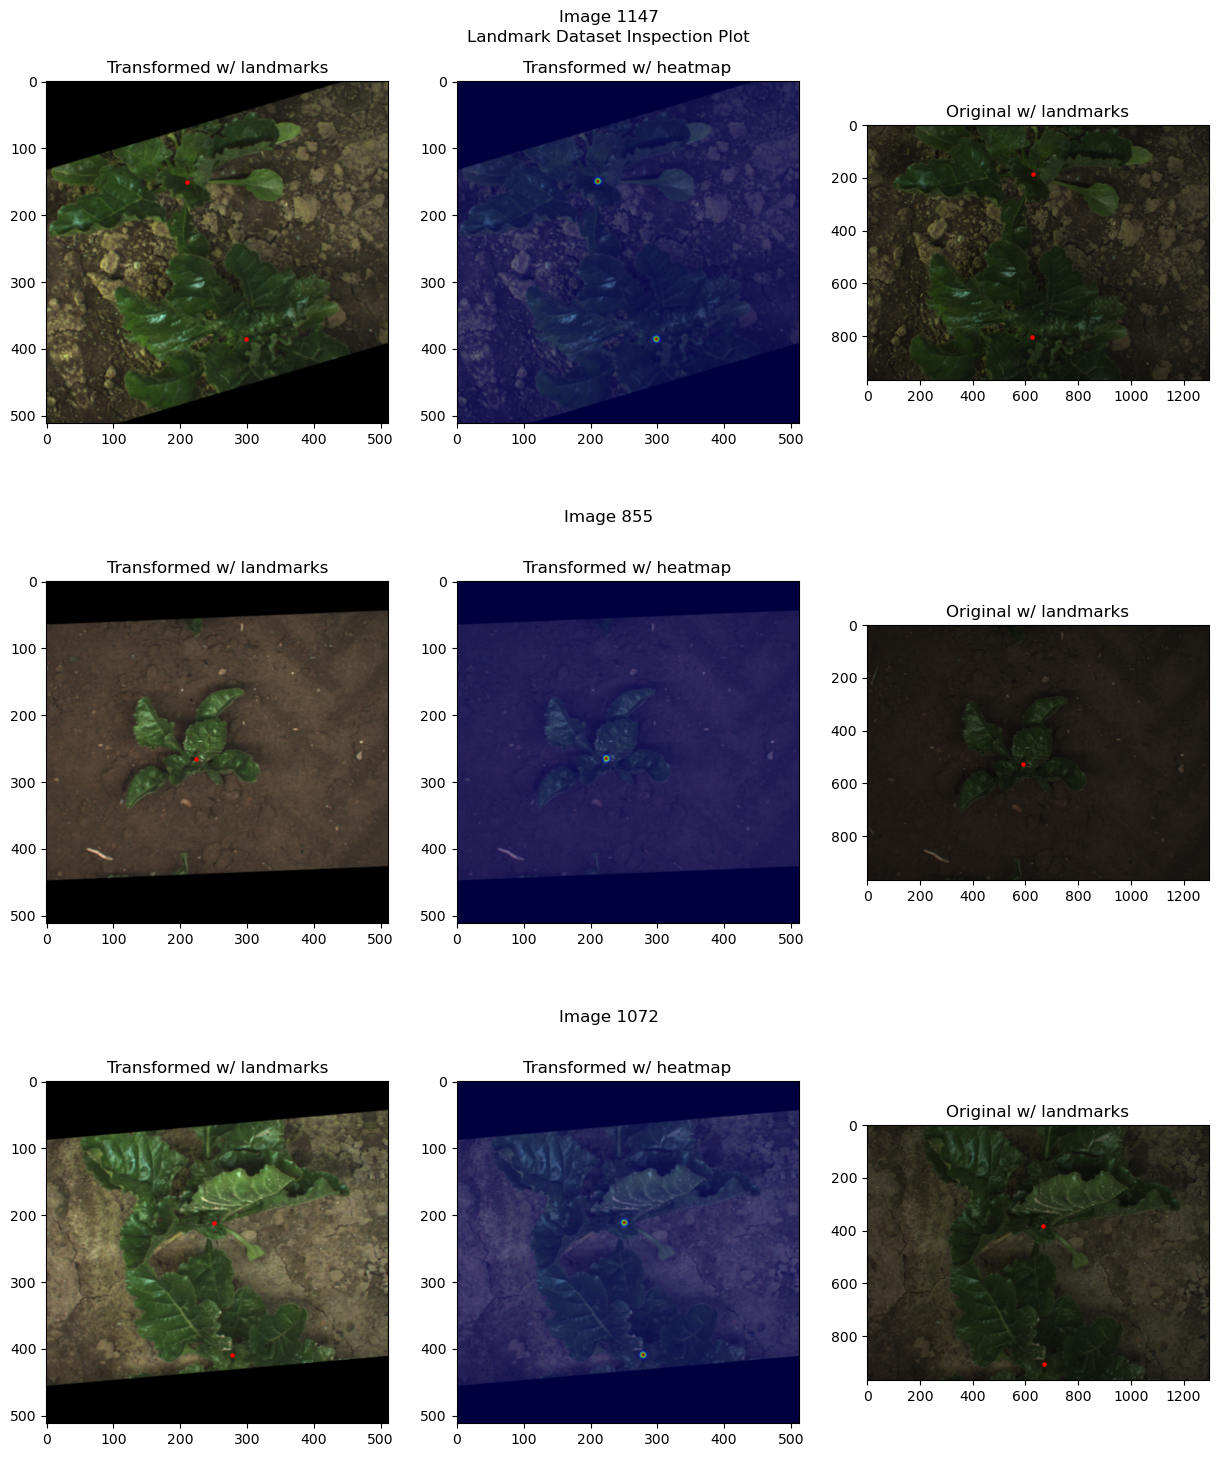

In [7]:
from landmarker.visualize import inspection_plot

# Plot the first 3 images from the training set
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
inspection_plot(ds_train, np.random.randint(0, len(ds_train), 3),
               heatmap_generator)
heatmap_generator.device = device # set the desired device back

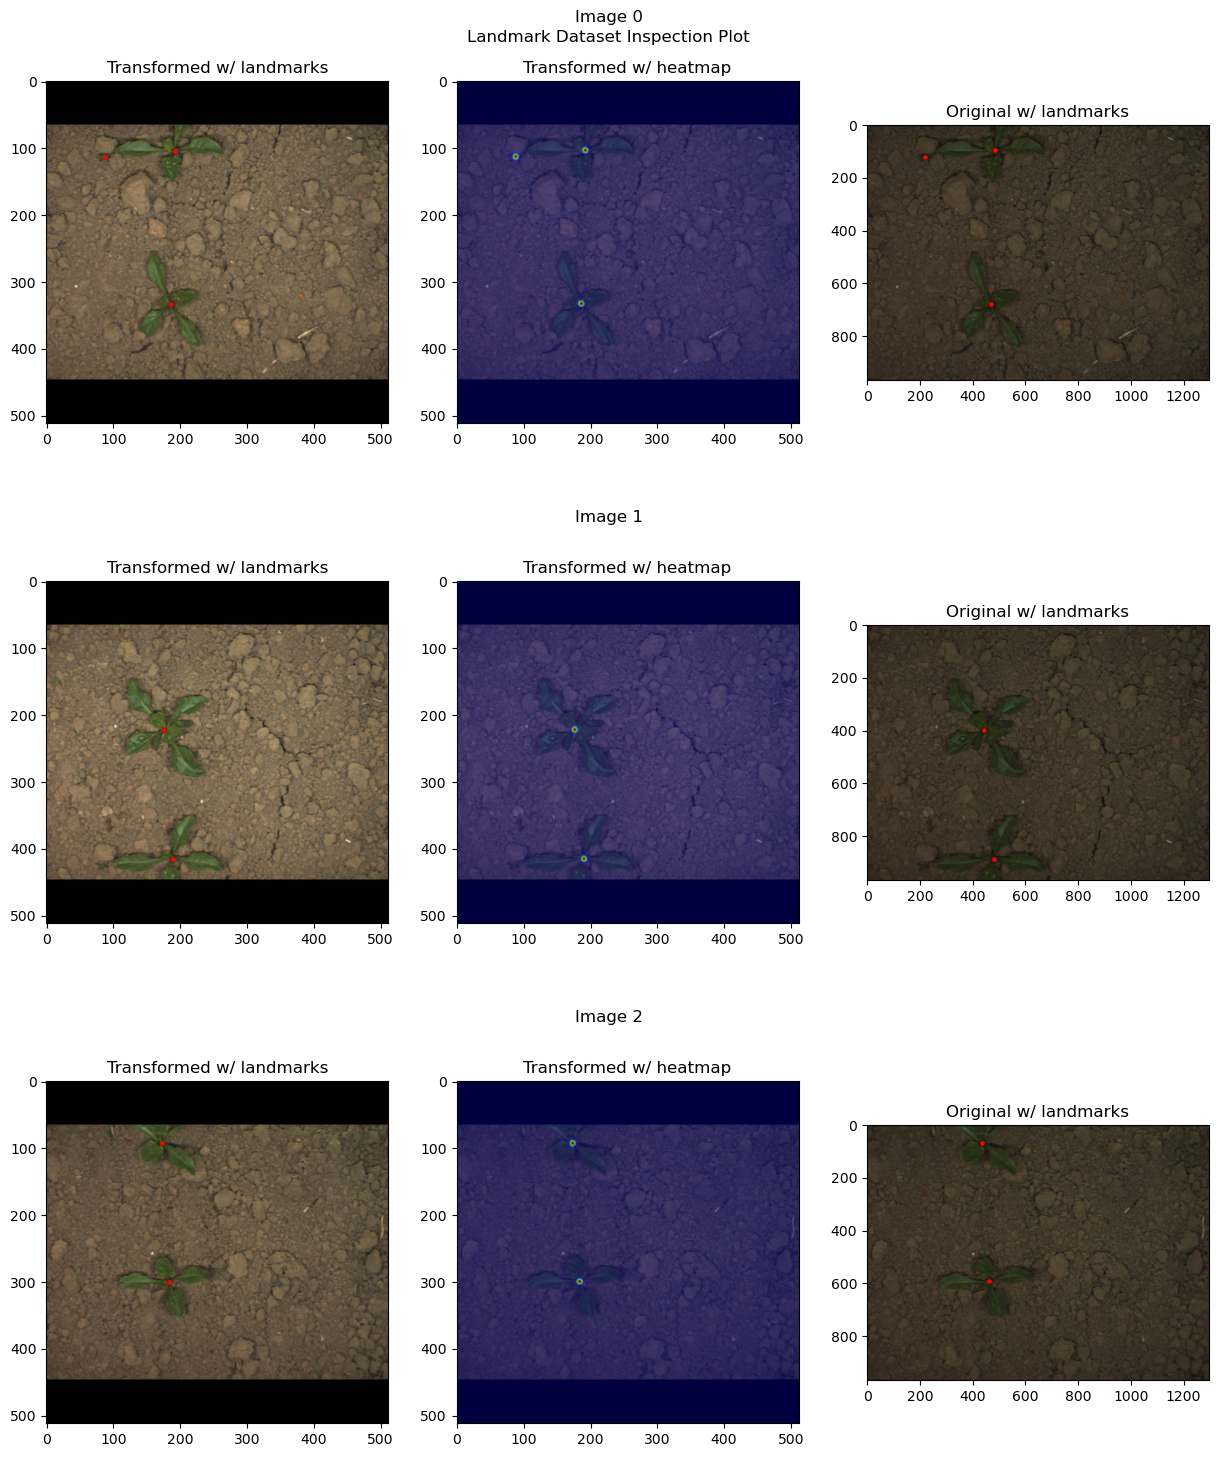

In [8]:
# Plot the first 3 images from the test1 set
heatmap_generator.device = "cpu" # because dataset tensors are still on cpu
inspection_plot(ds_test_A, range(3), heatmap_generator)
heatmap_generator.device = device # set the desired device back

## Training and initializing the SpatialConfiguration model

### Initializing the model, optimizer and loss function

In [9]:
from torch import nn
import segmentation_models_pytorch as smp

model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        decoder_channels=(256, 128, 64, 32, 32),
)

lr = 1e-4
batch_size = 4
epochs = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)

criterion = nn.BCEWithLogitsLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                          patience=10, verbose=True, cooldown=10)

/opt/anaconda3/envs/vision/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Setting the data loaders and split training set

In [10]:
split_lengths = [0.8, 0.2]
ds_train_train, ds_train_val = torch.utils.data.random_split(ds_train, split_lengths)
train_loader = DataLoader(ds_train_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(ds_train_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_A_loader = DataLoader(ds_test_A, batch_size=batch_size, shuffle=False, num_workers=0)
test_B_loader = DataLoader(ds_test_B, batch_size=batch_size, shuffle=False, num_workers=0)
test_C_loader = DataLoader(ds_test_C, batch_size=batch_size, shuffle=False, num_workers=0)

### Training the model

In [13]:
from landmarker.heatmap.decoder import heatmap_to_coord, heatmap_to_multiple_coord
from landmarker.metrics import point_error

from torch.nn.functional import sigmoid

from landmarker.metrics.metrics import multi_instance_point_error

def train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device):
    running_loss = 0
    model.train()
    for i, batch in enumerate(tqdm(train_loader)):
        images = batch["image"].to(device)
        landmarks = batch["landmark"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        heatmaps = heatmap_generator(landmarks)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def val_epoch(model, heatmap_generator, val_loader, criterion, device):
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for _, batch in enumerate(tqdm(val_loader)):
            images = batch["image"].to(device)
            landmarks = batch["landmark"].to(device)
            outputs = model(images)
            heatmaps = heatmap_generator(landmarks)
            loss = criterion(outputs, heatmaps)
            eval_loss += loss.item()
    return eval_loss / len(val_loader)

def train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device, epochs=1000):
    for epoch in tqdm(range(epochs)):
        ds_train.transform = train_transformd
        train_loss = train_epoch(model, heatmap_generator, train_loader, criterion, optimizer, device)
        ds_train.transform = None
        val_loss = val_epoch(model, heatmap_generator, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}")
        lr_scheduler.step(val_loss)

In [14]:
train(model, heatmap_generator, train_loader, val_loader, criterion, optimizer, device,
      epochs=epochs)

# model.load_state_dict(torch.load("model_static_unet_plant_centroids.pt"))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.0938 - Val loss: 0.0283


  0%|          | 0/280 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Evaluating the model

In [ ]:
pred_landmarks = []
true_landmarks = []
dim_origs = []
pixel_spacings = []
paddings = []
tp = []
fp = []
fn = []
test_mpe = 0
test_tp = 0
test_fp = 0
test_fn = 0
threshold = 0.05
window = 9
model.eval()
model.to(device)
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_A_loader)):
        images = batch["image"]
        landmarks = batch["landmark"]
        outputs = model(images.to(device)).detach().cpu()
        offset_coords = outputs.shape[1]-landmarks.shape[1]
        pred_landmarks_list, _ = heatmap_to_multiple_coord(sigmoid(outputs), window=window,
                                                           threshold=threshold,
                                                           method="argmax")
        pe_batch, tp_batch, fp_batch, fn_batch, pred_landmarks_torch = multi_instance_point_error(
            true_landmarks=landmarks, pred_landmarks=pred_landmarks_list, dim=(512, 512),
            dim_orig=batch["dim_original"], pixel_spacing=batch["spacing"],
            padding=batch["padding"], reduction="none")
        test_mpe += torch.nanmean(pe_batch).item()
        test_tp += torch.nansum(tp_batch).item()
        test_fp += torch.nansum(fp_batch).item()
        test_fn += torch.nansum(fn_batch).item()
        pred_landmarks.append(pred_landmarks_torch)
        true_landmarks.append(landmarks)
        dim_origs.append(batch["dim_original"])
        pixel_spacings.append(batch["spacing"])
        paddings.append(batch["padding"])
        tp.append(tp_batch)
        fp.append(fp_batch)
        fn.append(fn_batch)


test_mpe /= len(test_A_loader)

print(f"Test Mean PE: {test_mpe:.4f}")
print(f"Test TP: {test_tp:.4f}")
print(f"Test FP: {test_fp:.4f}")
print(f"Test FN: {test_fn:.4f}")

In [ ]:
from landmarker.metrics import sdr

sdr_test = sdr([4, 5, 10, 20], true_landmarks=torch.cat(true_landmarks, axis=0), pred_landmarks=torch.cat(pred_landmarks, axis=0),
               dim=(512, 512), dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
               padding=torch.cat(paddings, axis=0))
for key in sdr_test:
    print(f"SDR for {key}mm: {sdr_test[key]:.4f}")

In [ ]:
from landmarker.visualize.utils import prediction_inspect_plot_multi_instance
model.to("cpu")
prediction_inspect_plot_multi_instance(ds_test_A, model, range(3), threshold=threshold, activation=nn.Sigmoid())

In [ ]:
from landmarker.visualize import plot_cpe

plot_cpe(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0), dim=(512, 512),
            dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
            padding=torch.cat(paddings, axis=0), class_names=ds_test_A.class_names,
            group=False, title="CPE curve", save_path=None,
            stat='proportion', unit='pixels', kind='ecdf')

In [ ]:
from landmarker.visualize.evaluation import multi_instance_detection_report

multi_instance_detection_report(torch.cat(true_landmarks, axis=0), torch.cat(pred_landmarks, axis=0),
                                torch.cat(tp, axis=0), torch.cat(fp, axis=0), torch.cat(fn, axis=0), dim=(512, 512),
                                dim_orig=torch.cat(dim_origs, axis=0).int(), pixel_spacing=torch.cat(pixel_spacings, axis=0),
                                padding=torch.cat(paddings, axis=0), class_names=ds_test_A.class_names)